# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [1]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [2]:
rules_data_path = 'data/rules.tsv.xz'                       # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                       },
                       low_memory=True)                     # For Chris

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [3]:
# Show the list of column names and the number of rules.
print(df_rules.columns)
print(len(df_rules))


Index(['consequent_item', 'transaction_count', 'item_set_count',
       'antecedent_count', 'consequent_count', 'antecedent_items'],
      dtype='object')
1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`
* Support: how often do A and B appear together
* Confidence: Given A, how often is B true
* Lift: How much more likely is B true given A, as opposed to be B on its own

In [4]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

# df_rules = # Something goes here.
df_rules['support']=df_rules['item_set_count']/df_rules['transaction_count']
df_rules['confidence']=df_rules['item_set_count']/df_rules['antecedent_count']
df_rules['lift']=(df_rules['item_set_count']*df_rules['transaction_count'])/(df_rules['antecedent_count']*df_rules['consequent_count'])

df_rules.head(50)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
5,Fat Free Strawberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
6,Fat Free Blueberry Yogurt,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
7,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,147,117,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",0.000030,0.687075,19649.653061
8,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,147,117,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",0.000030,0.687075,19649.653061
9,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,3346083,101,117,147,"[Pineapple Yogurt 2%, Total 0% Raspberry Yogur...",0.000030,0.863248,19649.653061


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*

#Answer:
Yogurt is more likely to appear bought with other products- we use yogurt in combination with many things.

In [5]:
# Query the rule set if you have to to find out more.
df_lift_low=df_rules.sort_values('lift')
df_lift_low.head(60)


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
1048574,Advanced Action Gel Laundry Stain Remover,3346083,190,3346083,190,[],0.000057,0.000057,1.0
1038513,Beyond Chicken Grilled Strips,3346083,1049,3346083,1049,[],0.000314,0.000314,1.0
1038512,Condensed Chicken Noodle Soup,3346083,1049,3346083,1049,[],0.000314,0.000314,1.0
1038511,Dairy Free Grated Parmesan Style Topping,3346083,1049,3346083,1049,[],0.000314,0.000314,1.0
1038510,Grassmilk Raw Sharp Cheddar Cheese,3346083,1049,3346083,1049,[],0.000314,0.000314,1.0
1038509,Mozzarella di Bufala Campana,3346083,1049,3346083,1049,[],0.000314,0.000314,1.0
1038508,Nutella & Go!,3346083,1049,3346083,1049,[],0.000314,0.000314,1.0
1038507,Gluten Free Fusilli,3346083,1050,3346083,1050,[],0.000314,0.000314,1.0
1038506,Grands! Southern Homestyle Buttermilk Biscuits,3346083,1050,3346083,1050,[],0.000314,0.000314,1.0
1038505,Lemon Dish Liquid,3346083,1050,3346083,1050,[],0.000314,0.000314,1.0


In [6]:
df_lift_high=df_rules.sort_values('lift', ascending=False)
df_lift_high.head(60)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
6,Fat Free Blueberry Yogurt,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
5,Fat Free Strawberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
7,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,147,117,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",0.000030,0.687075,19649.653061
8,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,147,117,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",0.000030,0.687075,19649.653061
9,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,3346083,101,117,147,"[Pineapple Yogurt 2%, Total 0% Raspberry Yogur...",0.000030,0.863248,19649.653061


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [7]:
# Define df_rules_subset
c1=df_rules['antecedent_items'].apply(lambda x: len(x) == 1) #length of antecedent_items==1
df_rules_subset = df_rules[c1]  
df_rules_subset['antecedent_items']= df_rules_subset['antecedent_items'].apply(lambda x: str(x[0]) if len(x) == 1 else x) #list to string
c2=df_rules_subset['lift'].apply(lambda x: x>=5 and x<=20) #lift btwn 5 and 20
df_rules_subset=df_rules_subset[c2]  #
item_to_check="Hummus"
#replace items contaning hummus with hummus
df_rules_subset['consequent_item']= df_rules_subset['consequent_item'].apply(lambda x: "Hummus" if item_to_check in x else x) 
df_rules_subset['antecedent_items']= df_rules_subset['antecedent_items'].apply(lambda x: "Hummus" if item_to_check in x else x)

c3 = df_rules_subset.apply(lambda row: ((item_to_check in row['antecedent_items']) and (item_to_check not in row['consequent_item'])) or ((item_to_check in row['consequent_item']) and (item_to_check not in row['antecedent_items'])), axis=1)
# check for third condition
df_rules_subset=df_rules_subset[c3]
print(len(df_rules_subset)) #i got 25 im not sure why
df_rules_subset
# Something goes here. You can repeat this for as many steps as necessary. Technically, you can do it all in one shot. :)


25


/var/folders/s_/hz_rs82x1dd5dxbp3_yb1qlm0000gp/T/ipykernel_54778/240483682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_subset['antecedent_items']= df_rules_subset['antecedent_items'].apply(lambda x: str(x[0]) if len(x) == 1 else x) #list to string


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
377756,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,100,887,21405,Hummus,0.000030,0.112740,17.623731
387837,Clementines,3346083,174,1334,32194,Hummus,0.000052,0.130435,13.556738
416420,Hummus,3346083,345,1656,74172,Organic White Pita Bread,0.000103,0.208333,9.398434
419119,Hummus,3346083,293,1434,74172,Organic Whole Wheat Pita,0.000088,0.204324,9.217543
422178,Hummus,3346083,331,1655,74172,Mini Whole Wheat Pita Bread,0.000099,0.200000,9.022496
440198,Hummus,3346083,3119,17333,74172,Sea Salt Pita Chips,0.000932,0.179946,8.117800
442099,Organic Baby Carrots,3346083,258,1334,80493,Hummus,0.000077,0.193403,8.039749
463035,Hummus,3346083,151,933,74172,"Lentil Chips, Himalayan Pink Salt",0.000045,0.161844,7.301163
463988,Hummus,3346083,311,1929,74172,Garbanzo Beans No Salt Added,0.000093,0.161223,7.273189
476420,Hummus,3346083,512,3333,74172,Organic Whole Peeled Baby Carrots,0.000153,0.153615,6.929970


Build a network `graph_rules_subset` from the association rules subset.

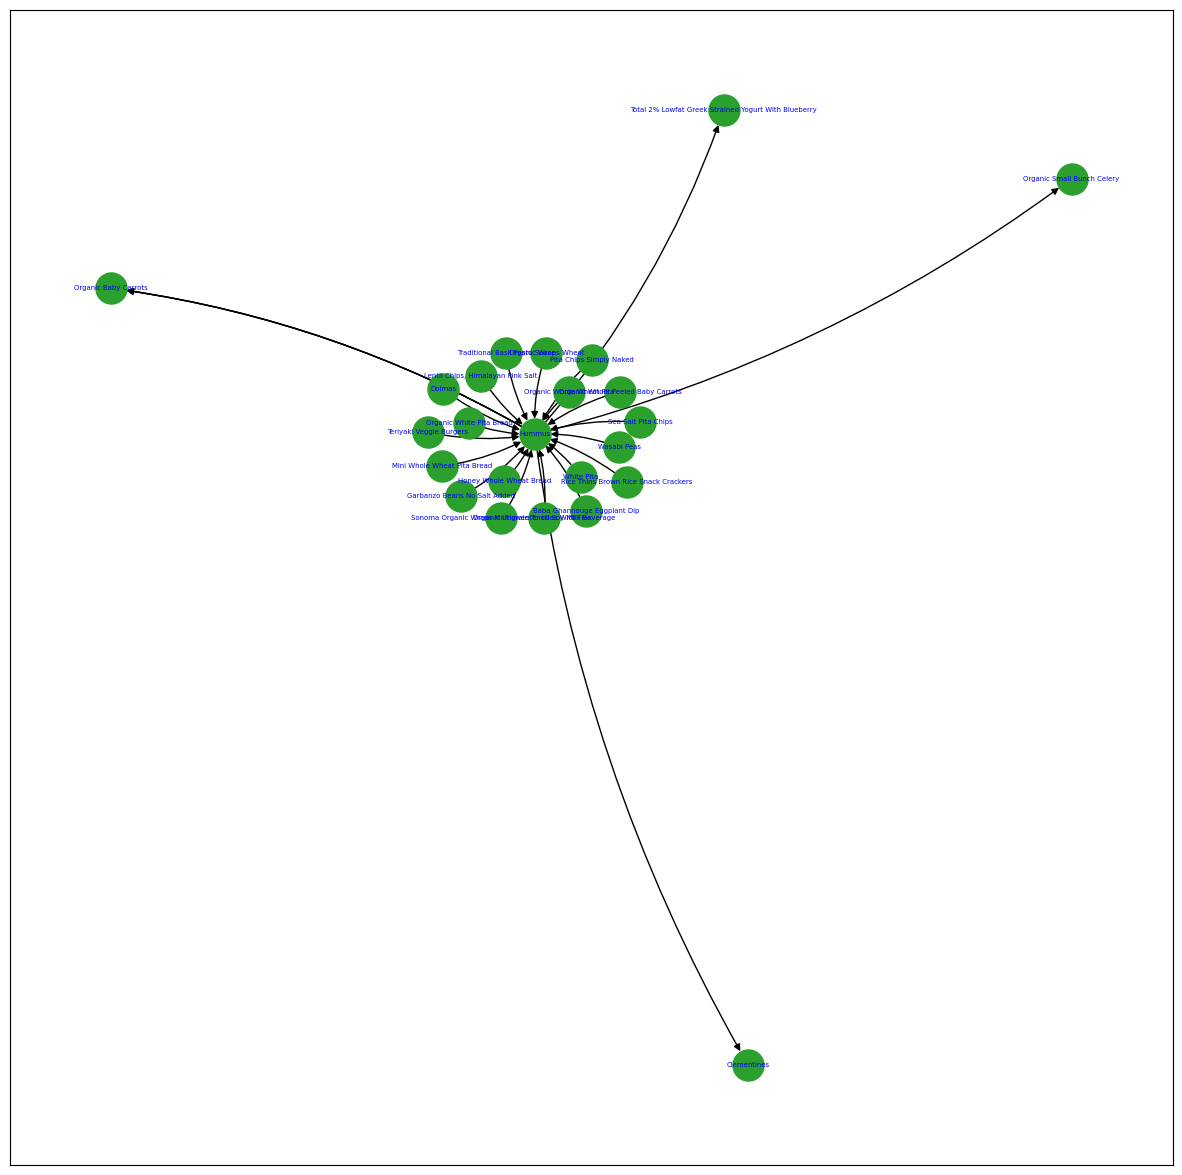

In [8]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.
from_nodes = df_rules_subset.antecedent_items
to_nodes = df_rules_subset.consequent_item
cxns = zip(from_nodes, to_nodes)
graph_rules_subset = nx.MultiDiGraph()
graph_rules_subset.add_edges_from(cxns
    # Something goes here.
)
plt.figure(1, figsize=(15, 15))
nx.draw_networkx(graph_rules_subset, arrows=True, node_size=500, font_size=5, node_color='tab:green', font_color='blue', connectionstyle='arc3, rad=0.1')
# Then render the graph.

What can you tell about people who buy hummus?
They buy a lot of items to eat with the hummus, like pita breads, chips, and carrots. they also seem to buy a lot of organic and healty alternatives like brown rice 

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`
* people buying this are buying other peppers and greens
Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [9]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

condition=df_rules.apply(lambda row: ('Orange Bell Pepper' in row['consequent_item']) or ('Organic Red Bell Pepper' in row['consequent_item']), axis=1)

df_rules[condition].sort_values('lift', ascending=False).head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
339613,Orange Bell Pepper,3346083,181,1448,4761,"[Organic Cilantro, Yellow Bell Pepper]",0.000054,0.125000,87.851371
344396,Orange Bell Pepper,3346083,169,1586,4761,"[Jalapeno Peppers, Yellow Bell Pepper]",0.000051,0.106557,74.889693
345322,Orange Bell Pepper,3346083,147,1424,4761,"[Bunched Cilantro, Yellow Bell Pepper]",0.000044,0.103230,72.551413
349168,Orange Bell Pepper,3346083,106,1054,5322,"[Banana, Limes, Yellow Bell Pepper]",0.000032,0.100569,63.230570
352236,Organic Red Bell Pepper,3346083,102,946,6443,"[Organic Blueberries, Organic Orange Bell Pepper]",0.000030,0.107822,55.996078
353414,Organic Orange Bell Pepper,3346083,189,1080,11005,"[Organic Bell Pepper, Organic Raspberries, Org...",0.000056,0.175000,53.208953
353543,Organic Orange Bell Pepper,3346083,145,834,11005,"[Organic Bell Pepper, Organic Raspberries, Org...",0.000043,0.173861,52.862612
354224,Organic Orange Bell Pepper,3346083,135,801,11005,"[Organic Bell Pepper, Organic Cucumber, Organi...",0.000040,0.168539,51.244577
354719,Organic Orange Bell Pepper,3346083,108,656,11005,"[Organic Bell Pepper, Organic Jalapeno Pepper]",0.000032,0.164634,50.057203
354884,Organic Orange Bell Pepper,3346083,110,674,11005,"[Bag of Organic Bananas, Organic Bell Pepper, ...",0.000033,0.163205,49.622593


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.